## Here i will import all the required libraries

In [123]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import svm, grid_search, datasets
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

# Import libraries required to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display

## Below i have defined a funtion to resize an image and unroll to feature vector. This function will be used to computed binned color features

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

## I have defined a class to store the positions of the windows that contain Car-Images for the prior 20 frames of the project video.

In [349]:
# Define a class to store detected boxes from previous video frame
class Save_vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prior_boxes = [] 
        
    def add_boxes(self, boxes):
        self.prior_boxes.append(boxes)
        if len(self.prior_boxes) > 20:
            # throw out oldest rectangle set(s)
            self.prior_boxes = self.prior_boxes[len(self.prior_boxes)-20:]

## Here i have defined a function to compute the color histogram of the given image

In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## The below function will be used to resize the training data to desired size

In [4]:
# Define a function to scale down the image to desired size

def resize_image(img, nrows=64, ncolumns=64):
    scale = max(img.shape[0], img.shape[1], nrows) / ncolumns  # at most 64 rows and columns
    img_resize = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    return img_resize

## GET_HOG_FEATURES function will call sklearn HOG function and returns a features and/or a visual representation of histogram of object gradient.

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


## Here i will test a sample training image to visualize the computed HOG

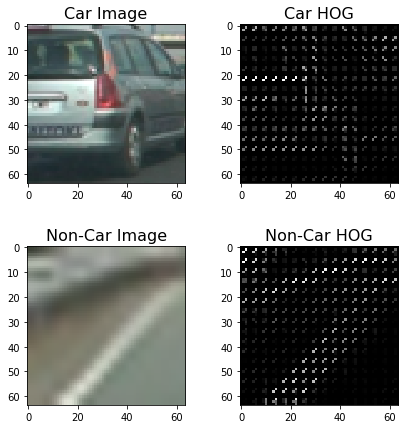

In [373]:
carimage = mpimg.imread('./vehicles/GTI_Left/image0168.png')
noncarimage = mpimg.imread('./non-vehicles/GTI/image23.png')
#image = image.astype(np.float32)/255
features,car_hog_image  = get_hog_features(carimage[:,:,2], 9, 4, 2, vis=True, feature_vec=False)
features,non_car_hog_image  = get_hog_features(noncarimage[:,:,2], 9, 4, 2, vis=True, feature_vec=False)
# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(carimage)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog_image, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncarimage)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(non_car_hog_image, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)


## Below i have defined a function to extract the required features from the given image channel. It obtains spatial features, color histogram features and HOG features and combines them together .

In [154]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image = resize_image(image,64,64)
        #print(image.shape)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Here i have define a sliding window function which slides over the image and obtains the cordinates of the windows

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Draw_boxes function will draw boxes on the windows identified through sliding window technique.

In [220]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Here i will use sliding window technique over a test image and will draw boxes to see if it works as expected.

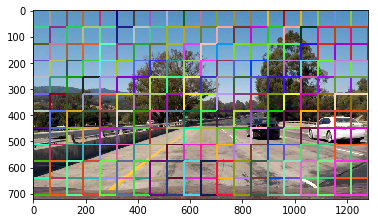

In [379]:
image = mpimg.imread('./test_images/test1.jpg')
#windows = slide_window(image, x_start_stop=[400, 1150], y_start_stop=[400, 550], 
#                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows2, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Function add_heat will create heatmap by adding the pixel value where windows overlap. 

In [102]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

## Next i will define a function to apply threshold on the heatmap.

In [103]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## After that i will define a function to draw boxes using labeled data

In [133]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero)
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## FIND_CARS function will perform the same functionality as extract_features but is more efficient in the way that HOG is computed once for the entire image and then subsampled later.  Extract_Features function is used for training the SVM but Find_Cars function is used for predicting.

In [319]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False):
    window_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = img_tosearch
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    #print(ch1.shape)
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #print('nxblocks:',nxblocks)
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #print('nyblocks:',nyblocks)
    nfeat_per_block = orient*cell_per_block**2
    #print('nfeat_per_block:',nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #print('nblocks_per_window:',nblocks_per_window)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nxsteps = nxsteps + 1
    #print('nxsteps:',nxsteps)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print('nysteps:',nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                startx  = xbox_left
                ytop_draw = np.int(ytop*scale)
                starty  = ytop_draw+ystart
                win_draw = np.int(window*scale)
                endx = xbox_left + win_draw
                endy = ytop_draw + win_draw + ystart
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                window_list.append(((startx, starty), (endx, endy)))
    #print(window_list)           
    #return draw_img,window_list
    return window_list

## The below function will perform vehicle detection on tracking on a single image.

In [380]:
def vehicle_detection_tracking_img(image):
    global clf
    global X_scaler
    global orient
    global pix_per_cell
    global cell_per_block
    global spatial_size
    global hist_bins
    
    
    win_list = []
    win_listx = []

    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    ystart = 380
    ystop = 580
    scale = 1.5
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)

    ystart = 380
    ystop = 580
    scale = 2
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)
    

    ystart = 380
    ystop = 640
    scale = 2.4
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)  
   
    
    ystart = 400
    ystop = 700
    scale = 2.4
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)
    
    
    ystart = 440
    ystop = 720
    scale = 2.8
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)
   


    #draw_img = draw_boxes(np.copy(image), win_list, color=(0, 0, 255), thick=6) 
    
    # Add heat to each box in box list
    heat = add_heat(heat,win_list)
    

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    #plt.imshow(heat)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels[1])
    # Draw Labeled boxes on the image
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap
    

## the below funciton will be used for vehicle detection and tracking on a video.

In [354]:
def vehicle_detection_tracking(image):
    global clf
    global X_scaler
    global orient
    global pix_per_cell
    global cell_per_block
    global spatial_size
    global hist_bins
    
    
    win_list = []
    win_listx = []

    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    ystart = 380
    ystop = 580
    scale = 1.5
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)

    ystart = 380
    ystop = 580
    scale = 2
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)
    

    ystart = 380
    ystop = 640
    scale = 2.3
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)  
   
    
    ystart = 400
    ystop = 680
    scale = 2.3
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)
    
    
    ystart = 400
    ystop = 680
    scale = 2.6
     
    win_listx = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=False)
    win_list.extend(win_listx)
   
    
    # save detected boxes 
    if len(win_list) > 0:
        svd.add_boxes(win_list)

    #draw_img = draw_boxes(np.copy(image), win_list, color=(0, 0, 255), thick=6) 
    
    # Add heat to each box in box list
    for box_list in svd.prior_boxes:
        heat = add_heat(heat, box_list)
        #heat = add_heat(heat,win_list)
    

    # Apply threshold to help remove false positives
    #print(1 + len(svd.prior_boxes)//2)
    heat = apply_threshold(heat,1 + len(svd.prior_boxes)//1)
    #plt.imshow(heat)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels[1])
    # Draw Labeled boxes on the image
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img
    

## Here i will train the support vector machine (SVM) using udacity provided Car and non-Car images.

In [207]:
# Read in cars and notcars
cars_images = glob.glob('./vehicles/*/*.png')
notcars_images = glob.glob('./non-vehicles/*/*.png')
cars = []
notcars = []
for image in cars_images:
    cars.append(image)
for image in notcars_images:
    notcars.append(image)

print(len(cars))
print(len(notcars))
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 3000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

print("extracting car features @ ",time.time())
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("extracting Non Car features @ ",time.time())
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Done extracting features @ ",time.time())
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#clf = LinearSVC()
#parameters = {'kernel':('linear', 'rbf'), 'C':[5, 10]}
#svr = svm.SVC()
#clf = grid_search.GridSearchCV(svr, parameters)
#clf.fit(iris.data, iris.target)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


8792
8968
extracting car features @  1508775751.855474
extracting Non Car features @  1508775825.274638
Done extracting features @  1508775890.877876
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1260
715.13 Seconds to train SVC...
Test Accuracy of SVC =  0.9963


In [30]:
print(clf.best_params_)

{'C': 5, 'kernel': 'linear'}


## Once the SVM is trained, i will run the pipeline to predict(detect) the cars on udacity provided test images and draw boxes (after removing false positives)

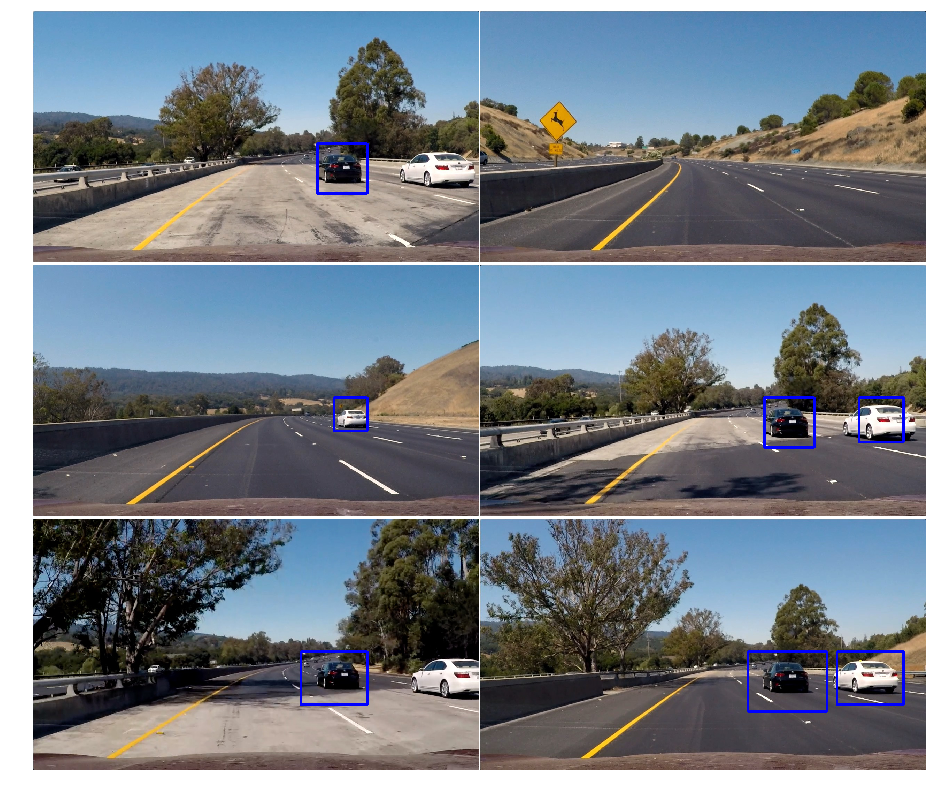

In [381]:
svd =  Save_vehicle_Detect()
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    img1, img2 = vehicle_detection_tracking_img(mpimg.imread(im))
    axs[i].imshow(img1,cmap='gray')
    axs[i].axis('off')

## i will also visualize the heatmap to see how the windows/boxes overlap

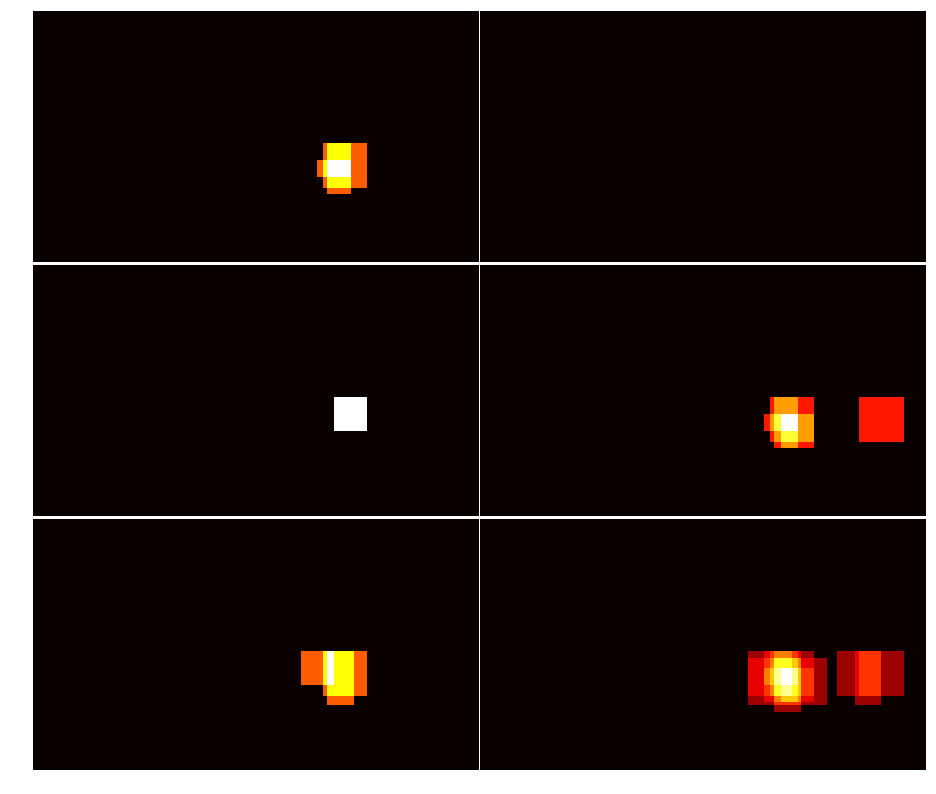

In [382]:
svd =  Save_vehicle_Detect()
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    img1, img2 = vehicle_detection_tracking_img(mpimg.imread(im))
    axs[i].imshow(img2,cmap='hot')
    axs[i].axis('off')

## I will also visualize how a multi scale implementation sliding window works on the test images irrespective of whether the cars are found or not

Number of boxes:  99


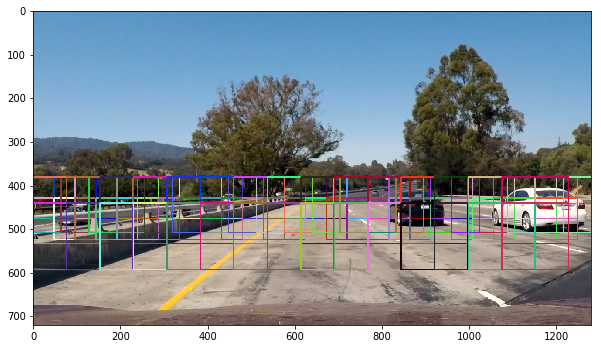

In [343]:

test_img = mpimg.imread('./test_images/test1.jpg')

rects = []
ystart = 380
ystop = 580
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=True))


ystart = 380
ystop = 580
scale = 2
rects.append(find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=True))

ystart = 380
ystop = 640
scale = 2.4
rects.append(find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=True))

ystart = 440
ystop = 680
scale = 2.4
rects.append(find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=True))


ystart = 440
ystop = 680
scale = 2.8
rects.append(find_cars(test_img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

## Finally i will run the pipeline on the project video.

In [356]:
svd =  Save_vehicle_Detect()
video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").set_end(30)
#clip1 = VideoFileClip("project_video.mp4").subclip(26,29)
clip1 = VideoFileClip("project_video.mp4")
#print(search_from_scratch)
video_clip = clip1.fl_image(vehicle_detection_tracking) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output_text.mp4
[MoviePy] Writing video project_video_output_text.mp4


100%|█████████▉| 1260/1261 [27:39<00:01,  1.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_text.mp4 

CPU times: user 25min 21s, sys: 1min 14s, total: 26min 36s
Wall time: 27min 42s
